In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib

In [2]:
import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    Spacingd, \
    ToTensord,  \
    DataStatsd, \
    ToDeviced
from monai.data import list_data_collate

import torch
import pytorch_lightning as pl
from torchsummary import summary

monai.config.print_config()

MONAI version: 0.9.dev2148
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 63c18670e4d46414eb3b5917fb0632e09bc3f8ed

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 8.1.0
Tensorboard version: 2.4.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.2.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import sys
sys.path.append(r'../util')
import vicra_toolbox

In [4]:
def delta_T_magnitude(T_ref, T):
    mag = np.sum(np.square(T-T_ref))
    return mag

In [5]:
import seaborn as sns

In [6]:
def delta_T_magnitude(T_ref, T):
    mag = np.sum(np.square(T-T_ref))
    return mag

In [7]:
def Relative_motion_A_to_B_12(img_vc1, img_vc2):
    A = np.pad(img_vc1, pad_width=1)
    B = np.pad(img_vc2, pad_width=1)
    R = vicra_toolbox.Relative_motion_A_to_B(A, B)
    return R[1:13]

In [8]:
## using for build a legal dataset from csv file
def build_legal_dataset(df,df_sample):
    mov_cols = ['PatientID','InjectionID','PatientType', 'ScanStart_x',
                'ThreeD_Cloud_x', 'ThreeD_Cloud_y', 'COD_nomask_x', 'COD_nomask_y', 'delta_t','DataType']
    df_sample = df_sample[mov_cols]
    scan_begin_time = 3600
    # Cols to keep
    active_cols = ['PatientID','InjectionID','PatientType','ScanStart',
                'ThreeD_Cloud', 'COD_nomask','M']
    final_cols = ['PatientID','InjectionID','PatientType', 'ScanStart_x',
                'ThreeD_Cloud_x', 'ThreeD_Cloud_y', 'COD_nomask_x', 'COD_nomask_y', 'T', 'delta_t','DataType']
    # Convert 12 matrix params to a single list in 'M'
    matrix_cols = ['VC_11', 'VC_12', 'VC_13', 'VC_14', 'VC_21', 'VC_22','VC_23', 'VC_24', 'VC_31', 'VC_32', 'VC_33', 'VC_34']
    M = df[matrix_cols].values.tolist()
    df['M'] = M
    df = df[active_cols]
    n = df_sample.shape[0]
    #build reference and moving time dataset
    for i in range(n):
        ref_index = df_sample.at[i,'ScanStart_x'] - scan_begin_time
        df_ref = df.loc[[ref_index]]
        mov_index = ref_index + df_sample.at[i,'delta_t']
        df_mov = df.loc[[mov_index]]
        df_temp = df_ref.merge(df_mov, on=['PatientID','InjectionID','PatientType'], how='left')
        df_temp['T'] = df_temp.apply(lambda row: 
                                vicra_toolbox.RotTransMatrix_6Params(
                                    vicra_toolbox.Relative_motion_A_to_B_12(row['M_x'], row['M_y']), 1), axis=1
                                )
        if (i == 0):
            df_final = df_temp
        else:
            df_final = pd.concat([df_final,df_temp])
    df_sample_1 = df_sample.merge(df_final, on=['PatientID','InjectionID','PatientType','ScanStart_x','ThreeD_Cloud_x','ThreeD_Cloud_y','COD_nomask_x','COD_nomask_y'], how='left')
    return df_sample_1


In [9]:
## using for build a legal dataset from csv file
def deal_dataframe(dir):
    df = pd.read_csv(dir)
    # Convert 12 matrix params to a single list in 'MATRIX'
    matrix_cols = ['VC_11', 'VC_12', 'VC_13', 'VC_14', 'VC_21', 'VC_22','VC_23', 'VC_24', 'VC_31', 'VC_32', 'VC_33', 'VC_34']
    M = df[matrix_cols].values.tolist()
    df['MATRIX'] = M
    df['T'] = df['MATRIX'].apply(lambda x: vicra_toolbox.RotTransMatrix_6Params(x, 1))
    df['delta_T'] = df['T'].apply(lambda t: delta_T_magnitude(df.loc[0,'T'], t))
    df['relative_T'] = df['MATRIX'].apply(lambda t: vicra_toolbox.RotTransMatrix_6Params(Relative_motion_A_to_B_12(df.loc[0,'MATRIX'], t), 1))
    df['delta_relative_T'] = df['relative_T'].apply(lambda t: delta_T_magnitude(df.loc[0,'relative_T'], t))
    ax = sns.lineplot(data=df, x="ScanStart", y="delta_T")
    ax = sns.lineplot(data=df, x="ScanStart", y="delta_relative_T") 
    plt.show()
    return(df) 

# Traning example: LW935
Read summary and samplings, then build legal dataframe.

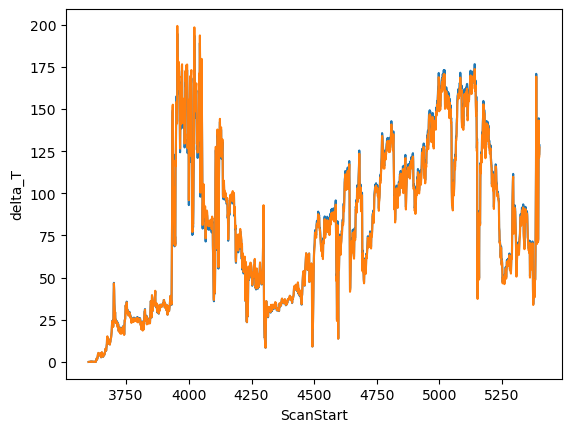

In [10]:
# EXAMPLE_DIR = r'/data7/ecr33/Project/R21_Grant/test_sim/FDG/20150824_lw935/15550'
EXAMPLE_DIR = r'/data16/public/registration-brain_PET/data/real/FDG/20150824_LW935/15550/Summary_LW935_3600_5400.csv'
df = deal_dataframe(EXAMPLE_DIR)
EXAMPLE_DIR = r'/data16/public/registration-brain_PET/sampling/Tianyi/simple_sampling/data_sample_random_n=6_LW935.csv'
df_sample = pd.read_csv(EXAMPLE_DIR)
#initialize the process for building a legal dataset
df_sample_p1 = build_legal_dataset(df,df_sample)

In [11]:
df_sample_p1.head(3)

,PatientID,InjectionID,PatientType,ScanStart_x,ThreeD_Cloud_x,ThreeD_Cloud_y,COD_nomask_x,COD_nomask_y,delta_t,DataType,M_x,ScanStart_y,M_y,T
0,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,89,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3689,"[0.990461, 0.022281, 0.135978, 10.764539, -0.0...","[0.09970426551263323, -0.4683485986183956, 3.2..."
1,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,42,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3642,"[0.990584, 0.008014, 0.13667, 9.356533, 0.0089...","[-1.0802719064382593, -0.014161342700811819, 1..."
2,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,9,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3609,"[0.991279, 0.018544, 0.130466, 10.40076, -0.00...","[0.13586252462872395, 0.024551388705031707, 0...."


In [ ]:
# EXAMPLE_DIR = r'/data7/ecr33/Project/R21_Grant/test_sim/FDG/20150824_lw935/15550'
EXAMPLE_DIR = r'/data16/public/registration-brain_PET/data/real/FDG/20150831_JB538/15592/Summary_JB538_3600_5400.csv'
df = deal_dataframe(EXAMPLE_DIR)
EXAMPLE_DIR = r'/data16/private/tz323/dev/dl-hmc/notebooks/data_sample_random_n=6_JB538.csv'
df_sample = pd.read_csv(EXAMPLE_DIR)
#initialize the process for building a legal dataset
df_sample_p2 = build_legal_dataset(df,df_sample)

In [ ]:
df_sample_1 = pd.concat([df_sample_p1,df_sample_p2])

In [12]:
#building transform
SPACING = [8.0]*3
KEYS = ['ThreeD_Cloud_x','ThreeD_Cloud_y']
SIZE = (32,32,32)

train_transforms = Compose([
    LoadImaged(keys=KEYS, reader='NibabelReader', as_closest_canonical=False),
    AddChanneld(keys=KEYS), 
    Orientationd(keys=KEYS, axcodes='RAS'),
    ToTensord(keys=KEYS)    
])

In [17]:
#building training dataloader
tr = df_sample_1.loc[df_sample_1['DataType']=='Train']

tr_dict = tr.to_dict('records')
for i in range(len(tr_dict)):
    x = tr_dict[i]['ThreeD_Cloud_x'].find('nii')
    fn_cloud1 = tr_dict[i]['ThreeD_Cloud_x'][0:x] + 'nii_monai_resize'
    x = x+3
    y = tr_dict[i]['ThreeD_Cloud_x'].find('3dcld')
    fn_cloud2 =  tr_dict[i]['ThreeD_Cloud_x'][x:y] + '3dcld_monai_rz.nii'
    tr_dict[i]['ThreeD_Cloud_x'] = fn_cloud1 + fn_cloud2
    
    x = tr_dict[i]['ThreeD_Cloud_y'].find('nii')
    fn_cloud1 = tr_dict[i]['ThreeD_Cloud_y'][0:x] + 'nii_monai_resize'
    x = x+3
    y = tr_dict[i]['ThreeD_Cloud_y'].find('3dcld')
    fn_cloud2 =  tr_dict[i]['ThreeD_Cloud_y'][x:y] + '3dcld_monai_rz.nii'
    tr_dict[i]['ThreeD_Cloud_y'] = fn_cloud1 + fn_cloud2

# Create the Dataset
ds_tr = monai.data.SmartCacheDataset(data=tr_dict,transform=train_transforms,replace_rate=0.25,cache_num=512,shuffle=True)
# Create the DataLoader
tr_loader = monai.data.DataLoader(ds_tr, batch_size=256, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 512/512 [00:05<00:00, 86.64it/s] 


In [ ]:
tr.head(5)

In [18]:
#building validation dataloader
val = df_sample_1.loc[df_sample_1['DataType']=='Validation']

val_dict = val.to_dict('records')
for i in range(len(val_dict)):
    x = val_dict[i]['ThreeD_Cloud_x'].find('nii')
    fn_cloud1 = val_dict[i]['ThreeD_Cloud_x'][0:x] + 'nii_monai_resize'
    x = x+3
    y = val_dict[i]['ThreeD_Cloud_x'].find('3dcld')
    fn_cloud2 =  val_dict[i]['ThreeD_Cloud_x'][x:y] + '3dcld_monai_rz.nii'
    val_dict[i]['ThreeD_Cloud_x'] = fn_cloud1 + fn_cloud2
    x = val_dict[i]['ThreeD_Cloud_y'].find('nii')
    fn_cloud1 = val_dict[i]['ThreeD_Cloud_y'][0:x] + 'nii_monai_resize'
    x = x+3
    y = val_dict[i]['ThreeD_Cloud_y'].find('3dcld')
    fn_cloud2 =  val_dict[i]['ThreeD_Cloud_y'][x:y] + '3dcld_monai_rz.nii'
    val_dict[i]['ThreeD_Cloud_y'] = fn_cloud1 + fn_cloud2
# Create the Dataset
ds_val = monai.data.CacheDataset(data=val_dict, transform=train_transforms)
# Create the DataLoader
val_loader = monai.data.DataLoader(ds_val, batch_size=256, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 1055/1055 [00:11<00:00, 93.09it/s] 


In [34]:
val.head(5)

,PatientID,InjectionID,PatientType,ScanStart_x,ThreeD_Cloud_x,ThreeD_Cloud_y,COD_nomask_x,COD_nomask_y,delta_t,DataType,M_x,ScanStart_y,M_y,T
6,LW935,15550,Real,3601,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,1622,Validation,"[0.991144, 0.016354, 0.13178, 10.188235, -0.00...",5223,"[0.9878, 0.03144, 0.152524, 11.343822, -0.0016...","[-0.058894434005912544, -0.8262300644340821, 9..."
7,LW935,15550,Real,3601,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,1243,Validation,"[0.991144, 0.016354, 0.13178, 10.188235, -0.00...",4844,"[0.989874, 0.03923, 0.136417, 11.292112, -0.01...","[-0.11421361715684952, -0.4001197835775714, 9...."
8,LW935,15550,Real,3601,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,508,Validation,"[0.991144, 0.016354, 0.13178, 10.188235, -0.00...",4109,"[0.985194, -0.008404, 0.171235, 6.863314, 0.04...","[-4.419583593866758, -0.929845933197657, 8.125..."
9,LW935,15550,Real,3601,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,640,Validation,"[0.991144, 0.016354, 0.13178, 10.188235, -0.00...",4241,"[0.987172, 0.001487, 0.159654, 7.718879, 0.024...","[-3.184257586134218, -0.347165966753199, 5.254..."
10,LW935,15550,Real,3601,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,1779,Validation,"[0.991144, 0.016354, 0.13178, 10.188235, -0.00...",5380,"[0.984421, 0.021516, 0.174508, 11.621164, 0.00...","[0.8027583130277414, 0.25216557017796704, 4.80..."


dict_keys(['PatientID', 'InjectionID', 'PatientType', 'ScanStart_x', 'ThreeD_Cloud_x', 'ThreeD_Cloud_y', 'COD_nomask_x', 'COD_nomask_y', 'delta_t', 'DataType', 'M_x', 'ScanStart_y', 'M_y', 'T', 'ThreeD_Cloud_x_meta_dict', 'ThreeD_Cloud_y_meta_dict', 'ThreeD_Cloud_x_transforms', 'ThreeD_Cloud_y_transforms'])
torch.Size([256, 1, 32, 32, 32])
image shape: torch.Size([32, 32, 32])


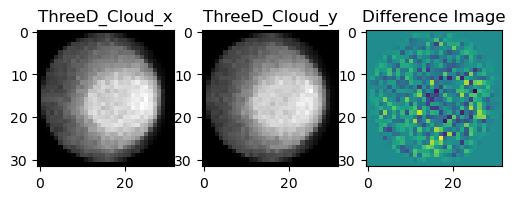

T: tensor([-1.0604, -0.3804,  1.1917,  0.7450,  0.2032,  0.5415],
       dtype=torch.float64)


In [19]:
#show point cloud data
check_data = monai.utils.misc.first(tr_loader)
print(check_data.keys())
print(check_data[KEYS[0]].shape)

num_display = 1
if check_data[KEYS[0]].shape[0] < num_display:
    num_display = check_data[KEYS[0]].shape[0]

for i in range(num_display):
    ref_image = check_data[KEYS[0]][i][0]
    mov_image = check_data[KEYS[1]][i][0]
    matrix = check_data['T'][i]
    
    print('image shape: {}'.format(ref_image.shape))

    slice_num = ref_image.shape[2]//2
    
    plt.figure('Check', (6, 3))
    plt.subplot(1, 3, 1)
    plt.title(KEYS[0])
    plt.imshow(ref_image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(KEYS[1])
    plt.imshow(mov_image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Difference Image')
    plt.imshow(ref_image[:,:,slice_num]-mov_image[:,:,slice_num])
    plt.show()
    print('T: {}'.format(matrix))

In [21]:
# Create a SmartCacheDataset Callback
class SmartCacheDatasetUpdate(pl.callbacks.base.Callback):

    def __init__(self, dataset):
        super().__init__()
                
        self.dataset = dataset
    
    def on_fit_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        """Called when fit begins."""
        print('Starting SmartCacheDataset')
        self.dataset.start()

    def on_fit_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        """Called when fit ends."""
        print('Stopping SmartCacheDataset')
        self.dataset.shutdown()

    def on_train_epoch_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        """Called when the train epoch start."""
        print('Updating SmartCacheDataset')
        self.dataset.update_cache()

In [22]:
class PETRegNet(pl.LightningModule):
    
    def __init__(self, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        
        self.feature_extractor = monai.networks.nets.DenseNet(
            spatial_dims=3, 
            in_channels=1, 
            out_channels=128,
            init_features=64, 
            growth_rate=32,
            dropout_prob=self.dropout
        )

        self.fwt_layers = torch.nn.Sequential(
            torch.nn.Linear(1, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128*2),            
        )

        self.regression_layers = torch.nn.Sequential(
            torch.nn.Linear(128*2, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 6),
        )
        
        self.loss_function = torch.nn.MSELoss()
        
    def forward(self, x1, x2, x_t):
        y1 = self.feature_extractor(x1)
        y2 = self.feature_extractor(x2)
        y = torch.cat([y1,y2], dim=-1)
        
        # Insert feature-wise transformation here
        # y is a b x 256 vector
        # So, we need to transform the time conditioning variable to match this
        x_t=x_t.float()
        x_fwt = self.fwt_layers(torch.transpose(x_t[None],0,-1))
        y = torch.mul(y, x_fwt)
        y = self.regression_layers(y)
        return y

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        monai.utils.misc.set_determinism(seed=42)
    
    
    def training_step(self, batch, batch_idx):
        x1 = batch["ThreeD_Cloud_x"]
        x2 = batch["ThreeD_Cloud_y"]
        xt= batch["delta_t"]
        transforms = batch["T"].float()
        outputs = self.forward(x1,x2,xt)

        loss = self.loss_function(outputs, transforms)        
        return {"loss": loss}
        
    
    def training_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    
    def validation_step(self, batch, batch_idx):
        x1 = batch["ThreeD_Cloud_x"]
        x2 = batch["ThreeD_Cloud_y"]
        xt= batch["delta_t"]
        transforms = batch["T"].float()
        outputs = self.forward(x1,x2,xt)
        
        loss = self.loss_function(outputs, transforms)
        return {"val_loss": loss}

    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)

        # Log the value for model checkpoint saving
        self.log('val_loss', avg_loss)

    def configure_optimizers(self):
        total_params = list(self.feature_extractor.parameters()) + list(self.regression_layers.parameters()) + list(self.fwt_layers.parameters())
        opt = torch.optim.Adam(total_params, lr=5e-4)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=100, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]

# !pip install torchinfo

In [23]:
from torchinfo import summary

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PETRegNet().to(device)
summary(model, [(1,1,32,32,32),(1,1,32,32,32),(1,1)])

Layer (type:depth-idx)                             Output Shape              Param #
PETRegNet                                          --                        --
├─DenseNet: 1-1                                    [1, 128]                  --
│    └─Sequential: 2-1                             [1, 1024, 1, 1, 1]        --
│    │    └─Conv3d: 3-1                            [1, 64, 16, 16, 16]       21,952
│    │    └─BatchNorm3d: 3-2                       [1, 64, 16, 16, 16]       128
│    │    └─ReLU: 3-3                              [1, 64, 16, 16, 16]       --
│    │    └─MaxPool3d: 3-4                         [1, 64, 8, 8, 8]          --
│    │    └─_DenseBlock: 3-5                       [1, 256, 8, 8, 8]         777,408
│    │    └─_Transition: 3-6                       [1, 128, 4, 4, 4]         33,280
│    │    └─_DenseBlock: 3-7                       [1, 512, 4, 4, 4]         1,804,416
│    │    └─_Transition: 3-8                       [1, 256, 2, 2, 2]         132,096
│    │   

In [26]:
MODEL_PATH = os.path.join('.','saved_model_miccai')
print('MODEL_PATH={}'.format(MODEL_PATH))

MODEL_PATH=./saved_model_miccai


In [ ]:
# initialise the LightningModule
model = PETRegNet(dropout=0.3)

# set up loggers and checkpoints
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_PATH,'logs')
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_PATH),
    filename="PETRegNet-{epoch}-{val_loss:.3f}",
    monitor='val_loss',
    save_last=True,
    save_top_k=4,
    mode='min'
)

# Create and add the dataset callback
dataset_callback = SmartCacheDatasetUpdate(dataset=ds_tr)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_PATH,'last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_PATH,'last.ckpt')

# initialise Lightning's trainer.
trainer = pl.Trainer(
    gpus=[0],
    max_epochs=20000,
    logger=tb_logger,
    callbacks=[dataset_callback,lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=50,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=tr_loader, val_dataloaders=val_loader)

# Check testing dataset performance

In [28]:
df_sample_1.head()

,PatientID,InjectionID,PatientType,ScanStart_x,ThreeD_Cloud_x,ThreeD_Cloud_y,COD_nomask_x,COD_nomask_y,delta_t,DataType,M_x,ScanStart_y,M_y,T
0,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,89,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3689,"[0.990461, 0.022281, 0.135978, 10.764539, -0.0...","[0.09970426551263323, -0.4683485986183956, 3.2..."
1,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,42,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3642,"[0.990584, 0.008014, 0.13667, 9.356533, 0.0089...","[-1.0802719064382593, -0.014161342700811819, 1..."
2,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,9,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3609,"[0.991279, 0.018544, 0.130466, 10.40076, -0.00...","[0.13586252462872395, 0.024551388705031707, 0...."
3,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,71,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3671,"[0.990441, 0.009602, 0.137605, 9.522077, 0.008...","[-1.0346842158860792, -0.10185175113443057, 2...."
4,LW935,15550,Real,3600,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,/data16/public/registration-brain_PET/data/rea...,7,Train,"[0.991115, 0.016597, 0.131969, 10.248551, -0.0...",3607,"[0.991229, 0.019141, 0.130765, 10.509351, -0.0...","[0.22712410490887436, 0.042185393485805855, 0...."


In [ ]:
##building testing dataloader
test = df_sample_1.loc[df_sample_1['DataType']=='Testing']

test_dict = test.to_dict('records')

for i in range(len(test_dict)):
    x = test_dict[i]['ThreeD_Cloud_x'].find('nii')
    fn_cloud1 = test_dict[i]['ThreeD_Cloud_x'][0:x] + 'nii_monai_resize'
    x = x+3
    y = test_dict[i]['ThreeD_Cloud_x'].find('3dcld')
    fn_cloud2 =  test_dict[i]['ThreeD_Cloud_x'][x:y] + '3dcld_monai_rz.nii'
    test_dict[i]['ThreeD_Cloud_x'] = fn_cloud1 + fn_cloud2
    #print(tr_dict[i]['ThreeD_Cloud_x'])
    x = test_dict[i]['ThreeD_Cloud_y'].find('nii')
    fn_cloud1 = test_dict[i]['ThreeD_Cloud_y'][0:x] + 'nii_monai_resize'
    x = x+3
    y = test_dict[i]['ThreeD_Cloud_y'].find('3dcld')
    fn_cloud2 =  test_dict[i]['ThreeD_Cloud_y'][x:y] + '3dcld_monai_rz.nii'
    test_dict[i]['ThreeD_Cloud_y'] = fn_cloud1 + fn_cloud2

# Create the Dataset
ds_test = monai.data.CacheDataset(data=test_dict, transform=train_transforms)
# Create the DataLoader
test_loader = monai.data.DataLoader(ds_test, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [ ]:
#calculate loss function and network output
saved_model_path = os.path.join(MODEL_PATH,'PETRegNet-epoch=39699-val_loss=0.098.ckpt')
loaded_model = PETRegNet.load_from_checkpoint(saved_model_path)

loaded_model.eval()
loaded_model.to(device)
loss = 0
loss_list = list()
time_list = list()
prediction_list = list()
y_list = list()

i=0
for test_data in test_loader:
    x1 = test_data['ThreeD_Cloud_x'].to(device)
    x2 = test_data['ThreeD_Cloud_y'].to(device)
    x_t = test_data['delta_t'].to(device)
    time = test_data['delta_t']
    y = test_data['T'].cpu().numpy()
    y_test = loaded_model(x1, x2, x_t).detach().cpu().numpy()

    loss = np.mean(np.square(y-y_test))
    i = i + 1
    loss_list.append(loss)
    time_list.append(time.numpy()[0])
    prediction_list.append(y_test)
    y_list.append(y)

df_results = pd.DataFrame()
df_results['Time'] = time_list
df_results['Loss'] = loss_list

In [34]:
df_results.describe()

,Time,Loss
count,1059.000000,1059.000000
mean,85.781870,0.049999
std,81.246135,0.161468
min,1.000000,0.000357
25%,26.000000,0.005652
50%,61.000000,0.012108
75%,121.500000,0.034961
max,531.000000,2.821864


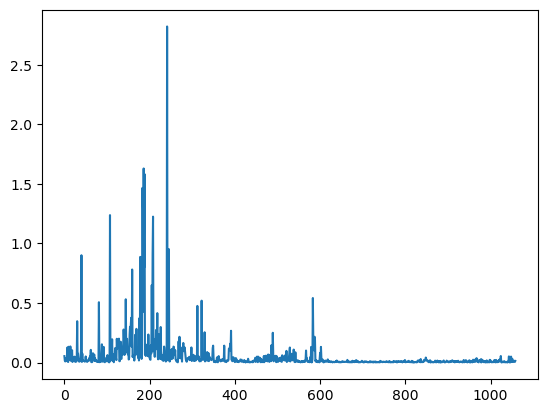

In [35]:
df_results['Loss'].plot()
plt.show()